In [29]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC


In [2]:
!pip install imblearn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/DACON/credit/train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('/content/drive/MyDrive/DACON/credit/test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('/content/drive/MyDrive/DACON/credit/sample_submission.csv')

In [6]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [117]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         10000 non-null  object 
 1   car            10000 non-null  object 
 2   reality        10000 non-null  object 
 3   child_num      10000 non-null  int64  
 4   income_total   10000 non-null  float64
 5   income_type    10000 non-null  object 
 6   edu_type       10000 non-null  object 
 7   family_type    10000 non-null  object 
 8   house_type     10000 non-null  object 
 9   DAYS_BIRTH     10000 non-null  int64  
 10  DAYS_EMPLOYED  10000 non-null  int64  
 11  FLAG_MOBIL     10000 non-null  int64  
 12  work_phone     10000 non-null  int64  
 13  phone          10000 non-null  int64  
 14  email          10000 non-null  int64  
 15  occyp_type     6848 non-null   object 
 16  family_size    10000 non-null  float64
 17  begin_month    10000 non-null  float64
dtypes: floa

## Data 전처리(occyp_type)

In [8]:
def occyptype_pre(data):
  data.loc[data["DAYS_EMPLOYED"] >= 0, "occyp_type"] = "No job"
  data["occyp_type"] = data["occyp_type"].fillna("unknown")
  return data



In [9]:
train = occyptype_pre(train)
test = occyptype_pre(test)
train  

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,unknown,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,unknown,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         10000 non-null  object 
 1   car            10000 non-null  object 
 2   reality        10000 non-null  object 
 3   child_num      10000 non-null  int64  
 4   income_total   10000 non-null  float64
 5   income_type    10000 non-null  object 
 6   edu_type       10000 non-null  object 
 7   family_type    10000 non-null  object 
 8   house_type     10000 non-null  object 
 9   DAYS_BIRTH     10000 non-null  int64  
 10  DAYS_EMPLOYED  10000 non-null  int64  
 11  FLAG_MOBIL     10000 non-null  int64  
 12  work_phone     10000 non-null  int64  
 13  phone          10000 non-null  int64  
 14  email          10000 non-null  int64  
 15  occyp_type     10000 non-null  object 
 16  family_size    10000 non-null  float64
 17  begin_month    10000 non-null  float64
dtypes: floa

In [10]:
train["occyp_type"].unique()

array(['unknown', 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'No job', 'Realty agents', 'Security staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Secretaries', 'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

### 데이터 전처리 (카드 수(num_card) 추가)

In [11]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'])]
test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(test['gender'],test['income_total'],test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'])]


In [12]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,identity
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,unknown,2.0,-6.0,1.0,F202500.0Commercial associate-13899-4709
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,F247500.0Commercial associate-11380-1540
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,M450000.0Working-19087-4434
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,F202500.0Commercial associate-15088-2092
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,F157500.0State servant-15037-2105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0,F225000.0State servant-12079-1984
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,unknown,2.0,-47.0,2.0,F180000.0Working-15291-2475
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0,F292500.0Working-10082-2015
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0,M171000.0Working-10145-107


In [13]:
def card_num(data):
  identity_counts = data['identity'].value_counts()
  identity_counts_df = pd.DataFrame(data = identity_counts)
  identity_counts_df.rename(columns= {"identity":'card_num'}, inplace= True)
  identity_counts_df["identity"]  = identity_counts_df.index
  identity_counts_df.iloc[:,[1,0]]
  data = pd.merge(left=data, right=identity_counts_df, how='left', on="identity", sort=False)
  return data


In [14]:
train = card_num(train)
test = card_num(test)

In [15]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,identity,card_num
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,unknown,2.0,-6.0,1.0,F202500.0Commercial associate-13899-4709,5
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,F247500.0Commercial associate-11380-1540,9
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,M450000.0Working-19087-4434,6
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,F202500.0Commercial associate-15088-2092,2
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,F157500.0State servant-15037-2105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0,F225000.0State servant-12079-1984,5
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,unknown,2.0,-47.0,2.0,F180000.0Working-15291-2475,1
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0,F292500.0Working-10082-2015,1
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0,M171000.0Working-10145-107,1


In [43]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,identity,card_num
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,No job,2.0,-60.0,M112500.0Pensioner-21990365243,3
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0,F135000.0State servant-18964-8671,2
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0,F69372.0Working-15887-217,2
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0,M112500.0Commercial associate-19270-2531,1
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0,F225000.0State servant-17822-9385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,F202500.0Working-18593-5434,3
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,M202500.0Working-10886-1315,2
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,F292500.0Working-21016-14018,5
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,unknown,2.0,-33.0,F180000.0Commercial associate-16541-1085,3


### SMOTE-NC 적용

In [48]:
X_train = train.drop('credit',axis = 1)
y_train = train["credit"]
X_test = test

In [54]:
X_train.keys()

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'identity', 'card_num'],
      dtype='object')

In [55]:
columns = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'identity', 'card_num']

In [59]:
len(columns)

20

In [60]:
from sklearn import preprocessing

def convert(data):
    number = preprocessing.LabelEncoder()
    data['occyp_type'] = number.fit_transform(data['occyp_type'])
    return data

In [62]:
X_train = convert(X_train)
X_test = convert(X_test)

In [63]:
X_train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,identity,card_num
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,12,2.0,-6.0,F202500.0Commercial associate-13899-4709,5
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,6,3.0,-5.0,F247500.0Commercial associate-11380-1540,9
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,7,2.0,-22.0,M450000.0Working-19087-4434,6
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,10,2.0,-37.0,F202500.0Commercial associate-15088-2092,2
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,7,2.0,-26.0,F157500.0State servant-15037-2105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,3,4.0,-2.0,F225000.0State servant-12079-1984,5
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,12,2.0,-47.0,F180000.0Working-15291-2475,1
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,3,2.0,-25.0,F292500.0Working-10082-2015,1
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,6,1.0,-59.0,M171000.0Working-10145-107,1


In [51]:
smotenc = SMOTENC([1],random_state=0)
X_resample, y_resampled = smotenc.fit_resample(X_train, y_train)


ValueError: ignored

## Continuos variable normalization

In [13]:
continuos_variable = ['child_num', 'income_total','DAYS_BIRTH', 'DAYS_EMPLOYED','family_size','begin_month','card_num']

In [14]:
train_continuos = train[continuos_variable]
test_continuos = test[continuos_variable]
train_continuos_copy = train[continuos_variable]
test_continuos_copy = test[continuos_variable]

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train_continuos)
train_continuos_scaled = scaler.transform(train_continuos)
test_continuos_scaled = scaler.transform(test_continuos)

train_df_continuos_scaled = pd.DataFrame(train_continuos_scaled, columns=train_continuos_copy.columns, index=list(train_continuos_copy.index.values))
test_df_continuos_scaled = pd.DataFrame(test_continuos_scaled, columns=test_continuos_copy.columns, index=list(test_continuos_copy.index.values))


In [16]:
test_df_continuos_scaled

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,card_num
0,-0.573599,-0.734287,-1.435662,2.227162,-0.214735,-2.045789,-0.598750
1,-0.573599,-0.513431,-0.715444,-0.492750,-0.214735,-0.596447,-0.870935
2,-0.573599,-1.157623,0.016912,-0.431254,-0.214735,-0.838004,-0.870935
3,-0.573599,-0.734287,-0.788275,-0.448087,-0.214735,-0.898393,-1.143119
4,-0.573599,0.369992,-0.443637,-0.497944,-0.214735,1.094452,-1.143119
...,...,...,...,...,...,...,...
9995,-0.573599,0.149136,-0.627143,-0.469204,-0.214735,0.430170,-0.598750
9996,-0.573599,0.149136,1.207198,-0.439241,-0.214735,-0.475668,-0.870935
9997,-0.573599,1.032559,-1.203840,-0.531645,-0.214735,-1.743843,-0.054381
9998,-0.573599,-0.071719,-0.138747,-0.437568,-0.214735,-0.415279,-0.598750


In [17]:
train = train.drop(columns=continuos_variable)
test = test.drop(columns=continuos_variable)
train = pd.concat([train,train_df_continuos_scaled], axis = 1)
test = pd.concat([test,test_df_continuos_scaled], axis = 1)

In [18]:
train

,gender,car,reality,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,credit,identity,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,card_num
0,F,N,N,Commercial associate,Higher education,Married,Municipal apartment,1,0,0,0,unknown,1.0,F202500.0Commercial associate-13899-4709,-0.573599,0.149136,0.490075,-0.463930,-0.214735,1.215231,-0.054381
1,F,N,Y,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1,0,0,1,Laborers,1.0,F247500.0Commercial associate-11380-1540,0.764529,0.590848,1.089621,-0.440878,0.876135,1.275620,1.034356
2,M,Y,Y,Working,Higher education,Married,House / apartment,1,0,1,0,Managers,2.0,M450000.0Working-19087-4434,-0.573599,2.578550,-0.744719,-0.461929,-0.214735,0.249003,0.217803
3,F,N,Y,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,0,Sales staff,0.0,F202500.0Commercial associate-15088-2092,-0.573599,0.149136,0.207081,-0.444893,-0.214735,-0.656836,-0.870935
4,F,Y,Y,State servant,Higher education,Married,House / apartment,1,0,0,0,Managers,2.0,F157500.0State servant-15037-2105,-0.573599,-0.292575,0.219220,-0.444988,-0.214735,0.007446,-1.143119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,State servant,Secondary / secondary special,Married,House / apartment,1,0,0,0,Core staff,1.0,F225000.0State servant-12079-1984,2.102658,0.369992,0.923252,-0.444108,1.967005,1.456788,-0.054381
26453,F,N,Y,Working,Higher education,Separated,House / apartment,1,0,0,0,unknown,2.0,F180000.0Working-15291-2475,0.764529,-0.071719,0.158765,-0.447679,-0.214735,-1.260729,-1.143119
26454,F,Y,N,Working,Secondary / secondary special,Civil marriage,With parents,1,0,0,0,Core staff,2.0,F292500.0Working-10082-2015,-0.573599,1.032559,1.398558,-0.444333,-0.214735,0.067835,-1.143119
26455,M,N,Y,Working,Incomplete higher,Single / not married,House / apartment,1,0,0,0,Laborers,2.0,M171000.0Working-10145-107,-0.573599,-0.160062,1.383563,-0.430454,-1.305605,-1.985400,-1.143119


## Categorical variable 전처리
[링크 텍스트](https:// [링크 텍스트](https://))

*   항목 추가
*   항목 추가



In [20]:
# occyp_type을 묶을 수 없을까?
train.nunique()

gender              2
car                 2
reality             2
child_num           9
income_total      249
income_type         5
edu_type            5
family_type         5
house_type          6
DAYS_BIRTH       6621
DAYS_EMPLOYED    3470
FLAG_MOBIL          1
work_phone          2
phone               2
email               2
occyp_type         20
family_size        10
begin_month        61
credit              3
identity         8727
card_num           23
dtype: int64

<function matplotlib.pyplot.show>

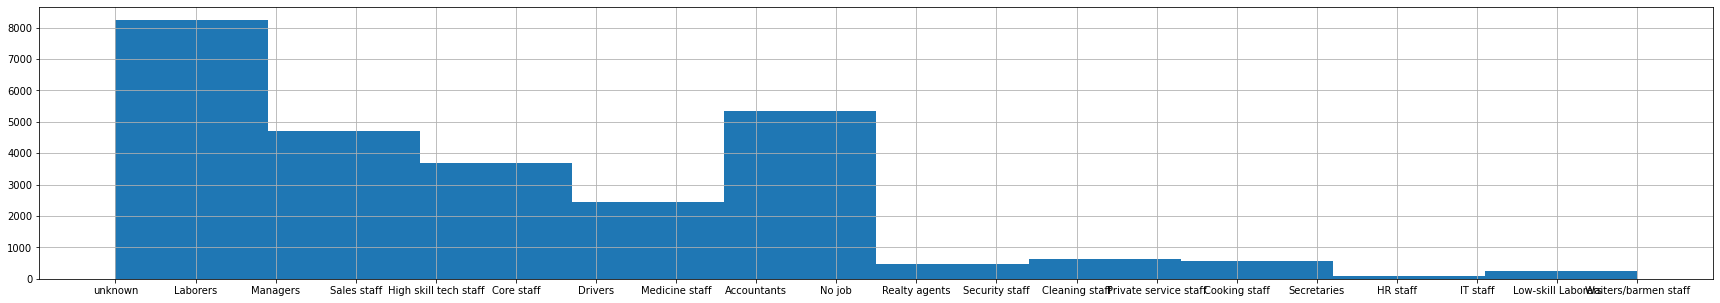

In [21]:
fig = plt.figure(figsize=(30,5))
train["occyp_type"].hist()
plt.show

In [29]:
train.keys()

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'credit', 'identity', 'child_num', 'income_total',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month',
       'card_num'],
      dtype='object')

In [22]:
cat_cols = ['occyp_type']

In [23]:
# 빈도수가 적은 카테고리 확인(1% 기준)
def find_minority_cats(cat_cols, data_df, composite_category='z', threshold=0.01):
    """ Find minority categories for each feature column, and create a 
        dictionary that maps those to selected composite category """
    minority_col_dict = {}
    minority_mapping_dict = {}
    
    # find all feature categories with less than 1% proportion
    for feature in cat_cols:
        minority_col_dict[feature] = []
        minority_mapping_dict[feature] = {}
        
        for category, proportion in data_df[feature].value_counts(normalize=True).iteritems():
            if proportion < threshold:
                minority_col_dict[feature].append(category)
                
                # map those minority cats to chosen composite feature
                minority_mapping_dict[feature] = { x : composite_category for x 
                                                  in minority_col_dict[feature]}
                
    return minority_mapping_dict, minority_col_dict

In [24]:
cat_min_mappings, minority_cols = find_minority_cats(["occyp_type"], train)
minority_cols

{'occyp_type': ['Private service staff',
  'Low-skill Laborers',
  'Waiters/barmen staff',
  'Secretaries',
  'Realty agents',
  'HR staff',
  'IT staff']}

In [25]:
cat_min_mappings

{'occyp_type': {'HR staff': 'z',
  'IT staff': 'z',
  'Low-skill Laborers': 'z',
  'Private service staff': 'z',
  'Realty agents': 'z',
  'Secretaries': 'z',
  'Waiters/barmen staff': 'z'}}

<function matplotlib.pyplot.show>

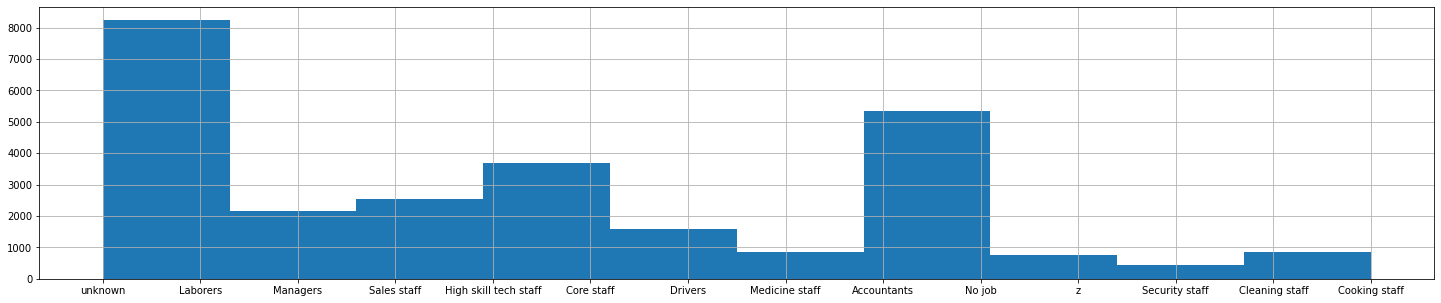

In [28]:
fig = plt.figure(figsize=(25,5))
train["occyp_type"].hist()
plt.show

In [27]:
train["occyp_type"] = train["occyp_type"].replace(cat_min_mappings["occyp_type"])
test["occyp_type"] = test["occyp_type"].replace(cat_min_mappings["occyp_type"])

In [63]:
test.nunique()

gender              2
car                 2
reality             2
income_type         5
edu_type            5
family_type         5
house_type          6
FLAG_MOBIL          1
work_phone          2
phone               2
email               2
occyp_type         14
identity         5571
child_num           6
income_total      208
DAYS_BIRTH       4675
DAYS_EMPLOYED    2665
family_size         7
begin_month        61
card_num           12
dtype: int64

In [64]:
#Data 합치기

data=pd.concat([train, test], axis=0)

In [65]:
data

,gender,car,reality,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,credit,identity,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,card_num
0,F,N,N,Commercial associate,Higher education,Married,Municipal apartment,1,0,0,0,unknown,1.0,F202500.0Commercial associate-13899-4709,-0.573599,0.149136,0.490075,-0.463930,-0.214735,1.215231,-0.054381
1,F,N,Y,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1,0,0,1,Laborers,1.0,F247500.0Commercial associate-11380-1540,0.764529,0.590848,1.089621,-0.440878,0.876135,1.275620,1.034356
2,M,Y,Y,Working,Higher education,Married,House / apartment,1,0,1,0,Managers,2.0,M450000.0Working-19087-4434,-0.573599,2.578550,-0.744719,-0.461929,-0.214735,0.249003,0.217803
3,F,N,Y,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,0,Sales staff,0.0,F202500.0Commercial associate-15088-2092,-0.573599,0.149136,0.207081,-0.444893,-0.214735,-0.656836,-0.870935
4,F,Y,Y,State servant,Higher education,Married,House / apartment,1,0,0,0,Managers,2.0,F157500.0State servant-15037-2105,-0.573599,-0.292575,0.219220,-0.444988,-0.214735,0.007446,-1.143119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,Working,Incomplete higher,Married,House / apartment,1,1,1,0,Accountants,NaN,F202500.0Working-18593-5434,-0.573599,0.149136,-0.627143,-0.469204,-0.214735,0.430170,-0.598750
9996,M,Y,Y,Working,Secondary / secondary special,Civil marriage,House / apartment,1,1,0,0,Laborers,NaN,M202500.0Working-10886-1315,-0.573599,0.149136,1.207198,-0.439241,-0.214735,-0.475668,-0.870935
9997,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Medicine staff,NaN,F292500.0Working-21016-14018,-0.573599,1.032559,-1.203840,-0.531645,-0.214735,-1.743843,-0.054381
9998,F,Y,N,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,0,unknown,NaN,F180000.0Commercial associate-16541-1085,-0.573599,-0.071719,-0.138747,-0.437568,-0.214735,-0.415279,-0.598750


In [66]:
#Binary variables
data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


In [67]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])

In [68]:
data=data.drop('FLAG_MOBIL',axis=1)

In [69]:
data = data.drop('identity', axis = 1)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         36457 non-null  int64  
 1   car            36457 non-null  int64  
 2   reality        36457 non-null  int64  
 3   income_type    36457 non-null  int64  
 4   edu_type       36457 non-null  int64  
 5   family_type    36457 non-null  int64  
 6   house_type     36457 non-null  int64  
 7   work_phone     36457 non-null  int64  
 8   phone          36457 non-null  int64  
 9   email          36457 non-null  int64  
 10  occyp_type     36457 non-null  int64  
 11  credit         26457 non-null  float64
 12  child_num      36457 non-null  float64
 13  income_total   36457 non-null  int64  
 14  DAYS_BIRTH     36457 non-null  float64
 15  DAYS_EMPLOYED  36457 non-null  float64
 16  family_size    36457 non-null  float64
 17  begin_month    36457 non-null  float64
 18  card_nu

In [71]:
train = data[:len(data)-10000]
test = data[len(data)-10000:]

In [72]:
test = test.drop('credit',axis=1)

In [73]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [74]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.669042	valid_1's multi_logloss: 0.749761
[200]	training's multi_logloss: 0.593465	valid_1's multi_logloss: 0.730569
[300]	training's multi_logloss: 0.534993	valid_1's multi_logloss: 0.719678
[400]	training's multi_logloss: 0.486725	valid_1's multi_logloss: 0.716091
Early stopping, best iteration is:
[435]	training's multi_logloss: 0.47203	valid_1's multi_logloss: 0.715732


====================================2============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.663751	valid_1's multi_logloss: 0.762447
[200]	training's multi_logloss: 0.58591	valid_1's multi_logloss: 0.746657
[300]	training's multi_logloss: 0.52801	valid_1's multi_logloss: 0.739564
Early stopping, best iteration is:
[283]	training's multi_logloss: 0.536448	va

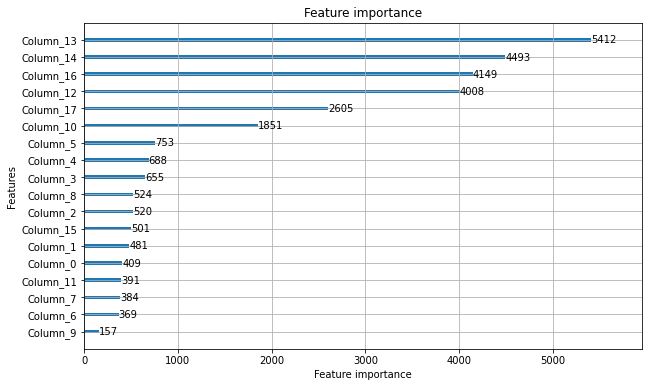

In [75]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(lgb, ax = ax)

In [76]:
data.keys()

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'work_phone', 'phone', 'email', 'occyp_type', 'credit',
       'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'family_size', 'begin_month', 'card_num'],
      dtype='object')

In [77]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [78]:
submit.to_csv('lgmb_v1.csv',index=False)

In [79]:
submit.head()

,index,0,1,2
0,26457,0.076495,0.154946,0.768558
1,26458,0.202028,0.159565,0.638407
2,26459,0.064143,0.094931,0.840926
3,26460,0.165431,0.079907,0.754662
4,26461,0.089795,0.220343,0.689862


In [1]:
from sklearn.metrics import accuracy_score